## Introduction

In this notebook, we will prepare the datasets for the hyperparameter optimization and determine the scaling metrics needed for the scope score calculation.

In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..','..')))
from Code.benchmark import Benchmark
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import skew
from sklearn.model_selection import StratifiedShuffleSplit
import os
import shutil
from tqdm import tqdm
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import colorsys

# Doyle colors
doyle_colors = ["#CE4C6F", "#1561C2", "#188F9D","#C4ADA2","#515798", "#CB7D85", "#A9A9A9"]
hist_color = "#dfdfdf"
# extension of palette with lighter and darker versions
def adjust_lightness(color, factor=1.2):
    """
    Function to make colors lighter (factor > 1) or darker (factor < 1).
    """
    r, g, b = mcolors.to_rgb(color)
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    l = max(0, min(1, l * factor))
    r, g, b = colorsys.hls_to_rgb(h, l, s)
    return mcolors.to_hex((r, g, b))

lighter = [adjust_lightness(c, 1.2) for c in doyle_colors]
darker  = [adjust_lightness(c, 0.7) for c in doyle_colors]
all_colors = doyle_colors + darker[::-1] + lighter[::-1] 

# Save the categorical colormap
cat_cmap = ListedColormap(all_colors, name="Doyle_cat")
plt.colormaps.register(cat_cmap)

# Define and save a continuous colormap
colors = [doyle_colors[1],"#FFFFFFD1",doyle_colors[0]]
cont_cmap = LinearSegmentedColormap.from_list("Doyle_cont", colors)
plt.colormaps.register(cont_cmap)

wdir = Path(".")

# General plt parameters
plt.rcParams.update({
    "axes.titlesize": 20,        # Subplot title
    "axes.labelsize": 16,        # X and Y labels
    "figure.titlesize": 24,      # Suptitle
    "xtick.labelsize": 14,       # X tick labels
    "ytick.labelsize": 14,       # Y tick labels
    "legend.fontsize": 14,       # Legend text
    "legend.title_fontsize": 14  # Legend titles
})

## Dataset selection

In the initial trends folder, we gained the following insights to inform the hyperparameter optimization:
* The trends for the average objective and Vendi score are opposing and a tradeoff point therefore needs to be found.
* A batch size of 1 is too small to yield competitive results under the constraint that the scope must be smaller than 10 rounds.
* There is some dependence on the size of the search space. E.g., strongly decreasing the scope size lowers the performance for otherwise similar parameters.
* Due to the origin of the rate data in the ArI dataset (3-parameter MLR model), the introduction of noise is helpful. A noise with a standard deviation of 20% of the dataset spread was determined as suitable.
* The performance strongly depends on the objective distribution of the dataset. Parallel optimization using datasets with different distributions was deemed to be preferred to ensure broad applicability of the resulting model.
* The balanced and greedy acquisition functions offer much higher performance than other tested acquisition functions.

Based on these considerations, we selected the following datasets for the parallel optimization of the algorithm hyperparameters. We added the aforementioned noise to each dataset using different random seeds.
* Dataset "medium": full ArI dataset with added noise (2055 compounds)
* Dataset "low": upper half of the ArI dataset (1028 samples)
* Dataset "high": lower half of the ArI dataset with stratified sampling to decrease the dataset size to 60% of the original size (617 samples)

## Dataset preparation

In [2]:
datasets = ["high","medium","low"]

# Loading the original dataset without any noise
df_original = pd.read_csv("./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered.csv",index_col=0,header=0)

Original, unprocessed dataset:
Length: 2055 samples.
Skewness: -0.18041
Mean: 1.27257


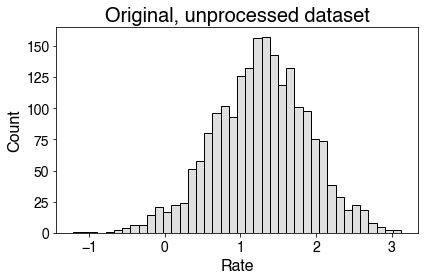

In [3]:
print("Original, unprocessed dataset:")
print(f"Length: {len(df_original)} samples.")
print(f"Skewness: {round(skew(df_original['rate']),5)}")
print(f"Mean: {round(df_original['rate'].mean(),5)}")
plt.figure(figsize=(6, 4))
plt.hist(df_original["rate"], color=hist_color, bins=40, edgecolor="k")
plt.title("Original, unprocessed dataset")
plt.xlabel("Rate")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()

### Dataset "medium"

This dataset has already been created in a different notebook (./../1_Initial_Trends/3_Noise_Dependence.ipynb) using the random seed 42.

In [4]:
# Load the data
df_medium = pd.read_csv(f"./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered_high-noise.csv",index_col=0,header=0)

In [5]:
# # Copy the file to the folder for the hyperparameter optimization datasets
# shutil.copy("./../0_Data/Datasets/Datasets_Initial_Trends/ArI_data_dft_unfiltered_high-noise.csv",
#             "./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-medium.csv")

Dataset 'medium':
Length: 2055 samples.
Skewness: -0.05097
Mean: 1.23908


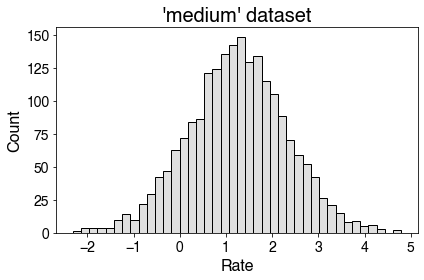

In [6]:
print("Dataset 'medium':")
print(f"Length: {len(df_medium)} samples.")
print(f"Skewness: {round(skew(df_medium['rate']),5)}")
print(f"Mean: {round(df_medium['rate'].mean(),5)}")
plt.figure(figsize=(6, 4))
plt.hist(df_medium["rate"], color=hist_color, bins=40, edgecolor="k")
plt.title("'medium' dataset")
plt.xlabel("Rate")
plt.ylabel("Count")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()

### Dataset "low"

In [7]:
# define a function for adding noise to the rate labels
def add_noise(df, noise_level,seed):
    # make some noise
    np.random.seed(seed)
    noise = np.random.normal(0.0, noise_level, size=len(df))
    # Add noise to the rates
    print(f"Adding noise with a standard deviation of {round(noise_level,5)} and random seed of {seed}.")
    noisy_data = df["rate"] + noise
    df_noisy = df.copy(deep=True)
    df_noisy["rate"] = noisy_data

    return df_noisy

Skewness before adding noise: 0.91321
Adding noise with a standard deviation of 0.8674 and random seed of 16.

Dataset 'low':
Length: 1028 samples.
Skewness: 1.18573
Mean: 2.1533


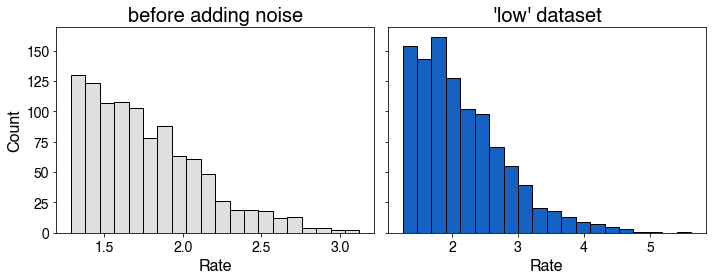

In [8]:
df_pruned_up = df_original.copy(deep=True)
df_pruned_up.sort_values(by="rate",inplace=True)
print(f"Skewness before adding noise: {round(skew(df_pruned_up[-1028:]['rate']),5)}")
# add noise
noise_level_up = 0.2 * (df_pruned_up["rate"].max() - df_pruned_up["rate"].min())  # noise level at 20% of the dataset spread
df_low = add_noise(df_pruned_up, noise_level = noise_level_up, seed = 16)  # different seed than df_medium
# get the upper half of the dataset
df_low = df_low.sort_values(by="rate")  # sort the dataframe by the rate objective
df_low = df_low.iloc[-1028:]  # only keep the upper half of samples (the full dataset is 2055 samples)

# save the dataset
df_low.to_csv(f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-low.csv",index=True,header=True)
# plot the dataset
print("")
print("Dataset 'low':")
print(f"Length: {len(df_low)} samples.")
print(f"Skewness: {round(skew(df_low['rate']),5)}")
print(f"Mean: {round(df_low['rate'].mean(),5)}")
fig,axes = plt.subplots(1,2,figsize=(10,4),sharey=True)
axes[0].hist(df_pruned_up[-1028:]["rate"], color=hist_color, bins=20, edgecolor="k")
axes[0].set_title("before adding noise")
axes[1].hist(df_low["rate"], color=all_colors[1], bins=20, edgecolor="k")
axes[0].set_xlabel("Rate")
axes[1].set_xlabel("Rate")
axes[0].set_ylabel("Count")
axes[1].set_title("'low' dataset")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()

### Dataset "high"

In [9]:
# define a function for the stratified sampling
def stratified_sampling(df, fraction, n_bins, col='rate', random_state=42):
    # create equally sized bins
    df = df.copy(deep=True)
    df['bin'] = pd.qcut(df[col], q=n_bins, duplicates='drop', labels=False)
    
    # Setup stratified sampler
    splitter = StratifiedShuffleSplit(n_splits=1, train_size=fraction, random_state=random_state)
    strat_sample = None
    # Get indices for stratified sample
    for train_idx, _ in splitter.split(df, df['bin']):
        strat_sample = df.iloc[train_idx]
        
    # Drop helper column before returning
    strat_sample = strat_sample.drop(columns=['bin'])
    
    return strat_sample

Skewness before adding noise: -1.13959
Adding noise with a standard deviation of 0.8674 and random seed of 2025.

Dataset 'high':
Length: 616 samples.
Skewness: -0.91687
Mean: 0.42491


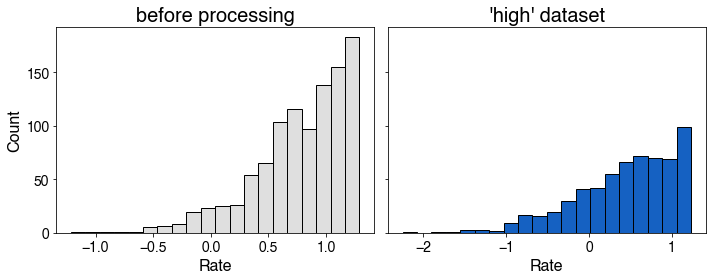

In [10]:
df_pruned_down = df_original.copy(deep=True)
df_pruned_down = df_pruned_down.sort_values(by="rate")  # sort the dataframe by the rate objective
print(f"Skewness before adding noise: {round(skew(df_pruned_down[:1029]['rate']),5)}")

# Stratified sampling  of the original dataset to 60% size
df_subset = stratified_sampling(df=df_pruned_down,fraction=0.6,n_bins=80,random_state=23)

# add noise (different random seed than in the "low" dataset)
noise_level_down = 0.2 * (df_pruned_down["rate"].max() - df_pruned_down["rate"].min())  # noise level at 20% of the dataset spread (original dataset)
df_high = add_noise(df_subset, noise_level = noise_level_down, seed = 2025)  # different seed than other datasets
df_high.sort_values(by="rate",inplace=True)
df_high = df_high.iloc[:(int(len(df_high)/2))]  # only keep the lower half of samples

# save the dataset
df_high.to_csv(f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-high.csv",index=True,header=True)

# plot the dataset
print("")
print("Dataset 'high':")
print(f"Length: {len(df_high)} samples.")
print(f"Skewness: {round(skew(df_high['rate']),5)}")
print(f"Mean: {round(df_high['rate'].mean(),5)}")

fig,axes = plt.subplots(1,2,figsize=(10,4),sharey=True)
axes[0].hist(df_pruned_down[:1029]["rate"], color=hist_color, bins=20, edgecolor="k")
axes[0].set_title("before processing")
axes[1].hist(df_high["rate"], color=all_colors[1], bins=20, edgecolor="k")
axes[0].set_xlabel("Rate")
axes[1].set_xlabel("Rate")
axes[0].set_ylabel("Count")
axes[1].set_title("'high' dataset")
plt.tick_params(axis='both', which='major')
plt.tight_layout()
plt.show()

### Run scopes to determine the normalization bounds

In [11]:
# for dset in datasets:
#     Benchmark().collect_data(
#         filename_labelled = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-{dset}.csv",  
#         name_results = f"./Results_Data/Bounds/40greedy-{dset}", objectives=['rate'], 
#         budget = 40, batches= [1,2,3,4], Vendi_pruning_fractions = [0], seeds = 20, 
#         acquisition_function_mode= "greedy", pruning_metric= "vendi_batch", init_sampling_method="random")

#     # most extreme vendi pruning for the datasets and a scope of 
#     # 40 samples for the different batch sizes
#     pruning_dict = {"high": {1: 8, 2: 18, 3: 27, 4: 35}, 
#                     "medium": {1: 12, 2: 24, 3: 35, 4: 44}, 
#                     "low": {1: 10, 2: 21, 3: 30, 4: 39}}
#     extreme_pruning_40 = pruning_dict[dset]

#     # Run the scopes
#     for batch in extreme_pruning_40:
#         Benchmark().collect_data(
#             filename_labelled = f"./../0_Data/Datasets/Datasets_Hyperpar_Opt/data-{dset}.csv",  
#             name_results = f"./Results_Data/Bounds/40explorative-{dset}/40explorative_b{batch}", objectives=['rate'], 
#             budget = 40, batches= [batch], Vendi_pruning_fractions = [extreme_pruning_40[batch]],
#             seeds = 20, acquisition_function_mode= "explorative", pruning_metric= "vendi_batch", 
#             init_sampling_method="random")

### Save the normalization bounds

In [12]:
# create a dataframe to save the normalization bounds
df_bounds = pd.DataFrame(np.nan,index=["obj_min","obj_max","vendi_min","vendi_max"],columns= datasets)
# Get the data
for dset in datasets:
    vendi_explore_max_40 = []
    for batch in [1,2,3,4]:
        df_explore_max_40 = Benchmark().heatmap_plot(type_results="vendi",
                                                     name_results=f"./Results_Data/Bounds/40explorative-{dset}/40explorative_b{batch}",
                                                     budget=40,show_plot=False)
        vendi_explore_max_40.append(df_explore_max_40.max().max())  # recording the highest Vendi score for this scope
    df_bounds.loc["vendi_max",dset] = max(vendi_explore_max_40)
    obj_explore_max_40 = []
    for batch in [1,2,3,4]:
        df_explore_max_40 = Benchmark().heatmap_plot(type_results="objective",
                                                     name_results=f"./Results_Data/Bounds/40explorative-{dset}/40explorative_b{batch}",
                                                     budget=40,show_plot=False)
        obj_explore_max_40.append(df_explore_max_40.min().min())  # recording the lowest average objective for this scope
    df_bounds.loc["obj_min",dset]  = min(obj_explore_max_40)
    df_greedy_40_vendi = Benchmark().heatmap_plot(type_results="vendi",name_results=f"./Results_Data/Bounds/40greedy-{dset}",budget=40,show_plot=False)
    df_bounds.loc["vendi_min",dset] = df_greedy_40_vendi.min().min()
    df_greedy_40_obj = Benchmark().heatmap_plot(type_results="objective",name_results=f"./Results_Data/Bounds/40greedy-{dset}",budget=40,show_plot=False)
    df_bounds.loc["obj_max",dset] = df_greedy_40_obj.max().max()

In [13]:
df_bounds.to_csv("./../0_Data/Datasets/Datasets_Hyperpar_Opt/bounds.csv",index=True,header=True)
df_bounds

,high,medium,low
obj_min,0.432225,1.174966,2.154690
obj_max,0.603510,1.984558,2.483439
vendi_min,2.392147,2.166708,2.043167
vendi_max,6.505295,6.313570,5.846067


# Figures for manuscript

dataset distributions

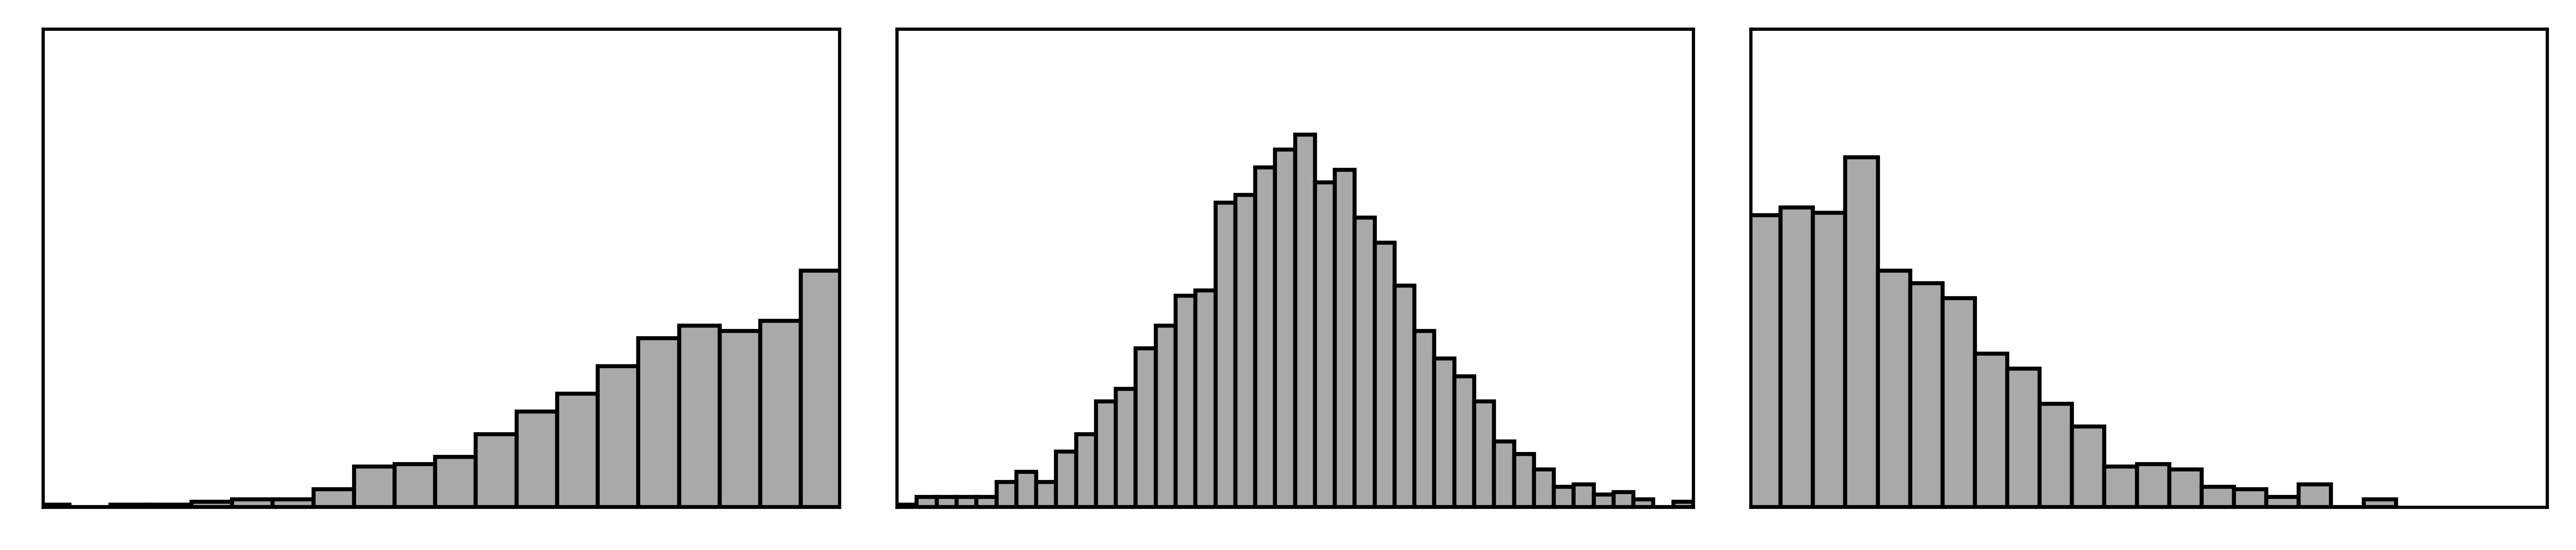

In [14]:
# Define bins from the full data range in df_medium
bin_edges = np.histogram_bin_edges(df_medium["rate"], bins=40, )

fig,axes = plt.subplots(1,3,figsize=(9,2),sharey=True,dpi= 600)
axes[0].hist(df_high["rate"],bins=bin_edges, color=all_colors[6], edgecolor="k")
axes[1].hist(df_medium["rate"],bins=bin_edges, color=all_colors[6], edgecolor="k")
axes[2].hist(df_low["rate"],bins=bin_edges, color=all_colors[6], edgecolor="k")

axes[0].set_ylim(0, 190)
axes[0].set_xlim(df_high["rate"].min(), df_high["rate"].max())
axes[1].set_xlim(df_medium["rate"].min(), df_medium["rate"].max())
axes[2].set_xlim(df_low["rate"].min(), df_low["rate"].max())
for ax in axes:
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

symbolic figure for the hyperparameter optimization

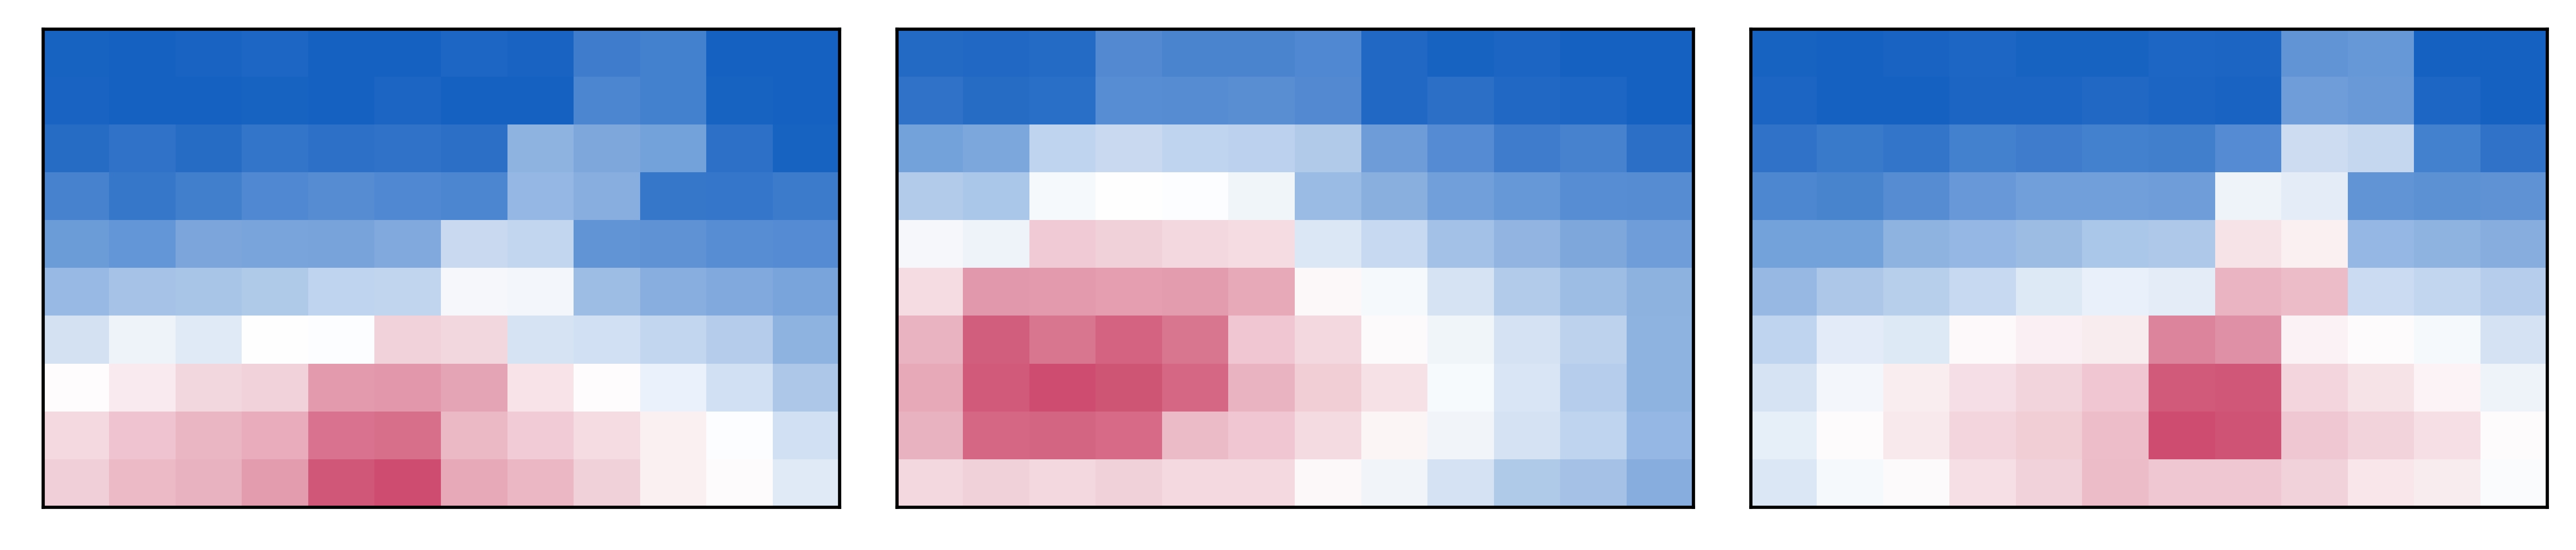

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm

def dummy_hyperpar_plot(
    ax,
    max_point=(8, 9), 
    min_point=(1, 6),
    sigmas=(4.0, 1.5),
    ridge_strength=0.3,
    ridge_width=1.2,
    noise_level=0.02,
    cbar=False):
    
    # Grid size
    rows, cols = 10, 12
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))

    max_row, max_col = max_point
    min_row, min_col = min_point
    sigma_x, sigma_y = sigmas

    # Gaussian
    gaussian = np.exp(-(((x - max_col) ** 2) / (2 * sigma_x**2) +
                        ((y - max_row) ** 2) / (2 * sigma_y**2)))

    # Ridge
    point_max = np.array([max_row, max_col])
    point_min = np.array([min_row, min_col])
    coords = np.dstack((y, x))
    vec = point_min - point_max
    vec_len = norm(vec)
    ap = coords - point_max
    t = np.clip(np.sum(ap * vec, axis=2) / (vec_len**2), 0, 1)
    proj = point_max + t[..., None] * vec
    dist_to_line = norm(coords - proj, axis=2)
    ridge = (dist_to_line < ridge_width) * ridge_strength

    # Combine and normalize
    data = gaussian + ridge
    np.random.seed(42)
    noise = np.random.normal(0, noise_level, size=(rows, cols))
    data += noise
    data[0:2, :] *= 0.5
    data = np.clip(data, 0, None)
    data = (data - data.min()) / (data.max() - data.min())

    # Plot on the provided axis
    im = ax.imshow(data, cmap="Doyle_cont", aspect="auto")

    ax.set_xticks([])
    ax.set_yticks([])

    return data


# === Create three side-by-side plots ===
fig, axes = plt.subplots(1, 3, figsize=(9, 2), dpi=600)

# Example: vary some parameters for each subplot
params = [
    {"max_point": (9, 4), "min_point": (0, 9), "sigmas": (6, 3), 
     "ridge_strength": 0.2, "ridge_width": 1, "noise_level": 0.02},
    {"max_point": (7, 2), "min_point": (0, 5), "sigmas": (6, 3), 
     "ridge_strength": 0.2, "ridge_width": 2, "noise_level": 0.02},
    {"max_point": (8, 6), "min_point": (0, 9), "sigmas": (6, 3), 
     "ridge_strength": 0.4, "ridge_width": 1, "noise_level": 0.02},
]
for ax, p in zip(axes, params):
    dummy_hyperpar_plot(ax=ax, **p)

plt.tight_layout()
plt.show()


performance bars for the scope score definition

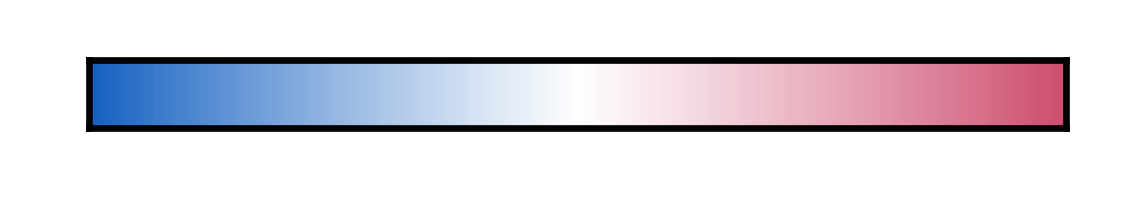

In [16]:
values = np.linspace(0, 10,300)
def strip_plot(x,figsize=(2.1,0.15)):
    cmap = plt.get_cmap("Doyle_cont")

    # Normalize values to 0–1 for colormap mapping
    norm = plt.Normalize(vmin=values.min(), vmax=values.max())

    # Create a 2D array (1 row, many columns)
    color_data = np.tile(x, (10, 1))

    fig, ax = plt.subplots(figsize=figsize,dpi=600)
    im = ax.imshow(color_data, aspect="auto", cmap=cmap, norm=norm,
                extent=[x.min(), x.max(), 0, 1])

    ax.set_yticks([])
    ax.set_xticks([])
    plt.show()
strip_plot(x=values)

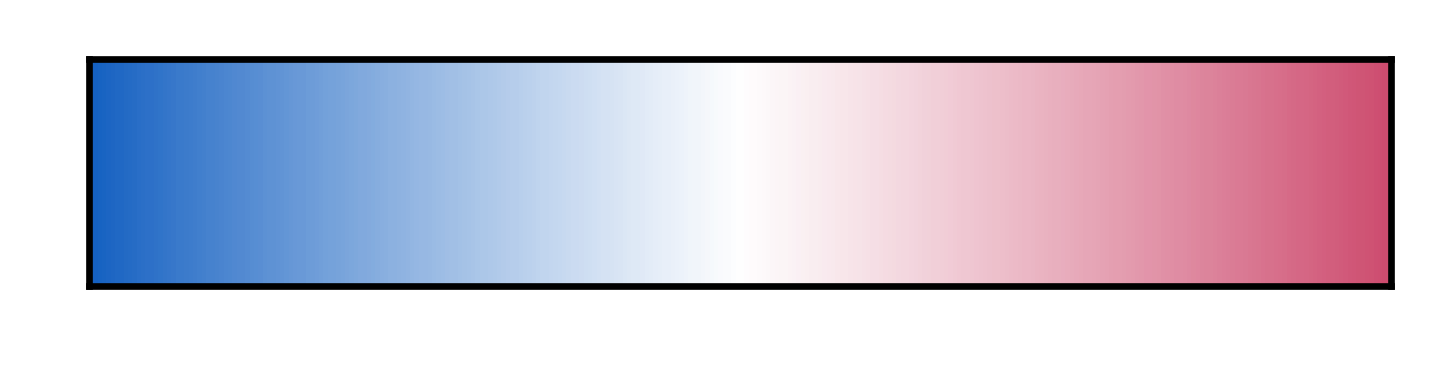

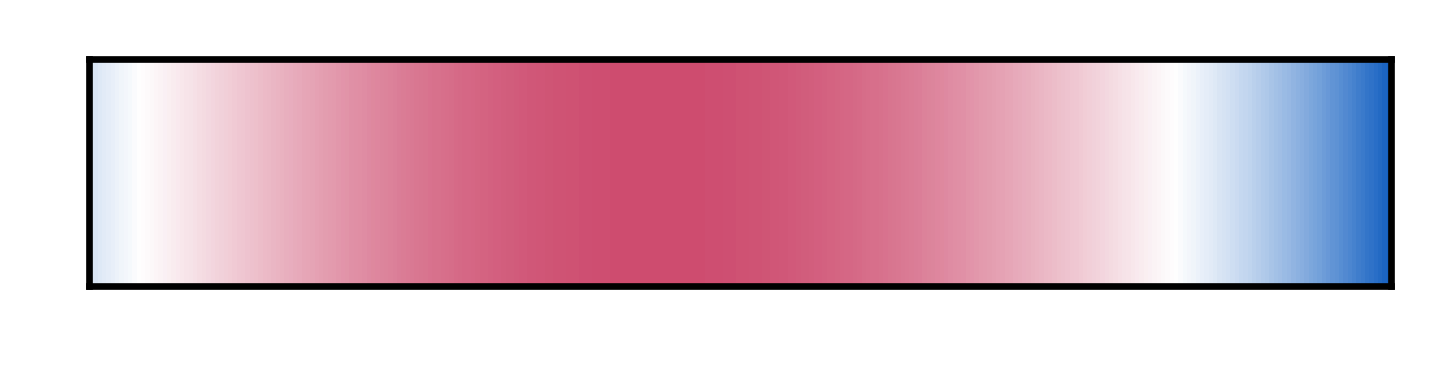

In [17]:
values = np.linspace(0, 10,300)
strip_plot(x=values,figsize =(2.8,0.5))
x = np.linspace(0, np.sqrt(15)+3, 300)
values = -0.1*(x-3)**2+10
strip_plot(x=values,figsize =(2.8,0.5))

symbolic plot of the analysis of the pareto solutions

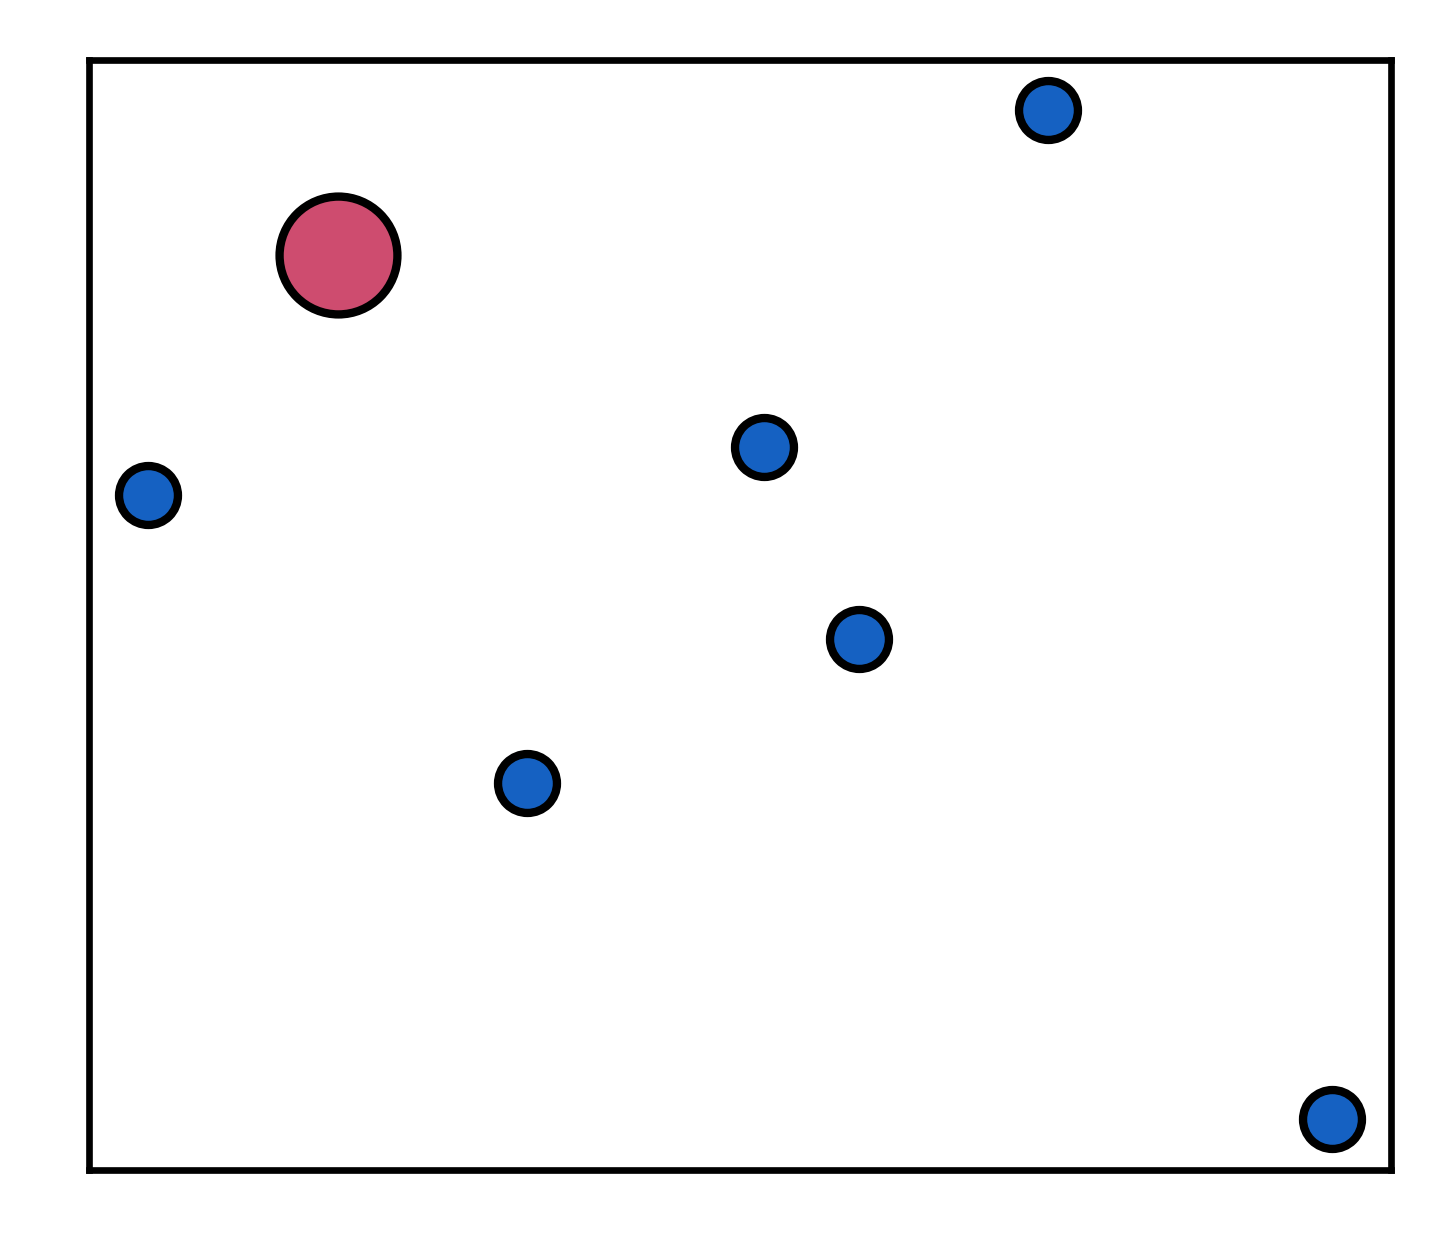

In [18]:
dummy_pareto = pd.DataFrame([[7,5.5],[6,6.5],[4.5,6.8],[5.8,6.9],[6.4,7.6],[5.3,6.2]])
dummy_pareto_top = pd.DataFrame([[4.9,7.3]])
plt.figure(figsize=(2.8, 2.45),dpi=600)
plt.scatter(dummy_pareto[0],dummy_pareto[1],s=50,c=all_colors[1],edgecolors="k",linewidths=1)
plt.scatter(dummy_pareto_top[0],dummy_pareto_top[1],s=200,c=all_colors[0],edgecolors="k",linewidths=1.0)
plt.xticks([])
plt.yticks([])
plt.show()

